<a href="https://colab.research.google.com/github/bhuvighosh3/Final-Year-Project/blob/main/Hypothesis_testing_on_UPFD_Old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# preprocessing

In [ ]:
# Assuming train_data and test_data are lists of PyG data objects
datasets = train_data + test_data  # Combine train and test data

# Extract edge indices and labels from all data objects
edges = []
node_labels = {}
for data in datasets:
    edge_index = data.edge_index.numpy()  # Convert tensor to NumPy
    label = data.y.item()  # Convert label tensor to scalar

    for src, tgt in zip(edge_index[0], edge_index[1]):
        edges.append((src, tgt, label))  # Append label along with source and target
        node_labels[src] = label
        node_labels[tgt] = label

# Create a DataFrame
df_edges = pd.DataFrame(edges, columns=["source", "target", "label"])

# Display the DataFrame
df_edges = df_edges[df_edges['label'] == 1]
df_edges

# Count occurrences of each (source, target) pair
df_edges = df_edges.copy()  # Ensure modifications don't affect a slice
df_edges['weight'] = df_edges.groupby(['source', 'target'])['source'].transform('count')

# Drop duplicates to keep only unique edges with their respective weights
df_edges = df_edges.drop_duplicates().reset_index(drop=True)

# Create adjacency matrix using NetworkX
G = nx.from_pandas_edgelist(df_edges, source="source", target="target", create_using=nx.DiGraph())

In [ ]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Density: {nx.density(G):.4f}")


Number of nodes: 198
Number of edges: 9162
Average degree: 92.55
Density: 0.2349


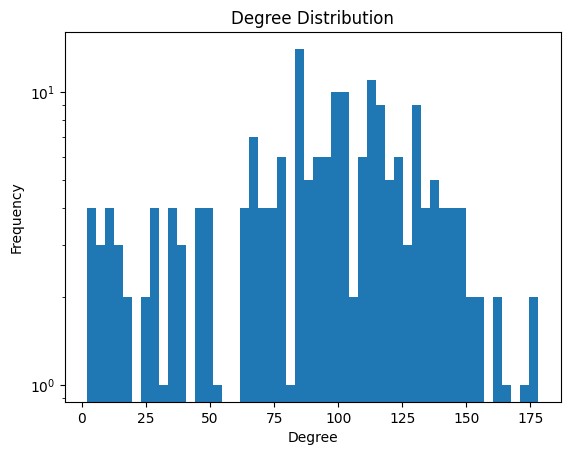

In [ ]:
import matplotlib.pyplot as plt

degrees = [d for _, d in G.degree()]
plt.hist(degrees, bins=50, log=True)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()


In [ ]:
# Compute centralities
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

# Find top 5 most influential nodes
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by Degree Centrality:", top_degree)
print("Top nodes by Betweenness Centrality:", top_betweenness)
print("Top nodes by PageRank:", top_pagerank)


Top nodes by Degree Centrality: [(24, 0.9035532994923857), (7, 0.8883248730964466), (0, 0.8781725888324873), (31, 0.8426395939086294), (1, 0.8274111675126903)]
Top nodes by Betweenness Centrality: [(141, 0.007963271711854653), (181, 0.0076326849800375796), (102, 0.007491875762586068), (193, 0.007351461552955028), (93, 0.005832709564598236)]
Top nodes by PageRank: [(181, 0.03466640955161225), (180, 0.024434976039804865), (193, 0.02044837095899592), (189, 0.020205099952095077), (179, 0.019585023363939864)]


In [ ]:
%pip install python-louvain
import community.community_louvain as community_louvain
partition = community_louvain.best_partition(G.to_undirected())

Number of detected communities: 4


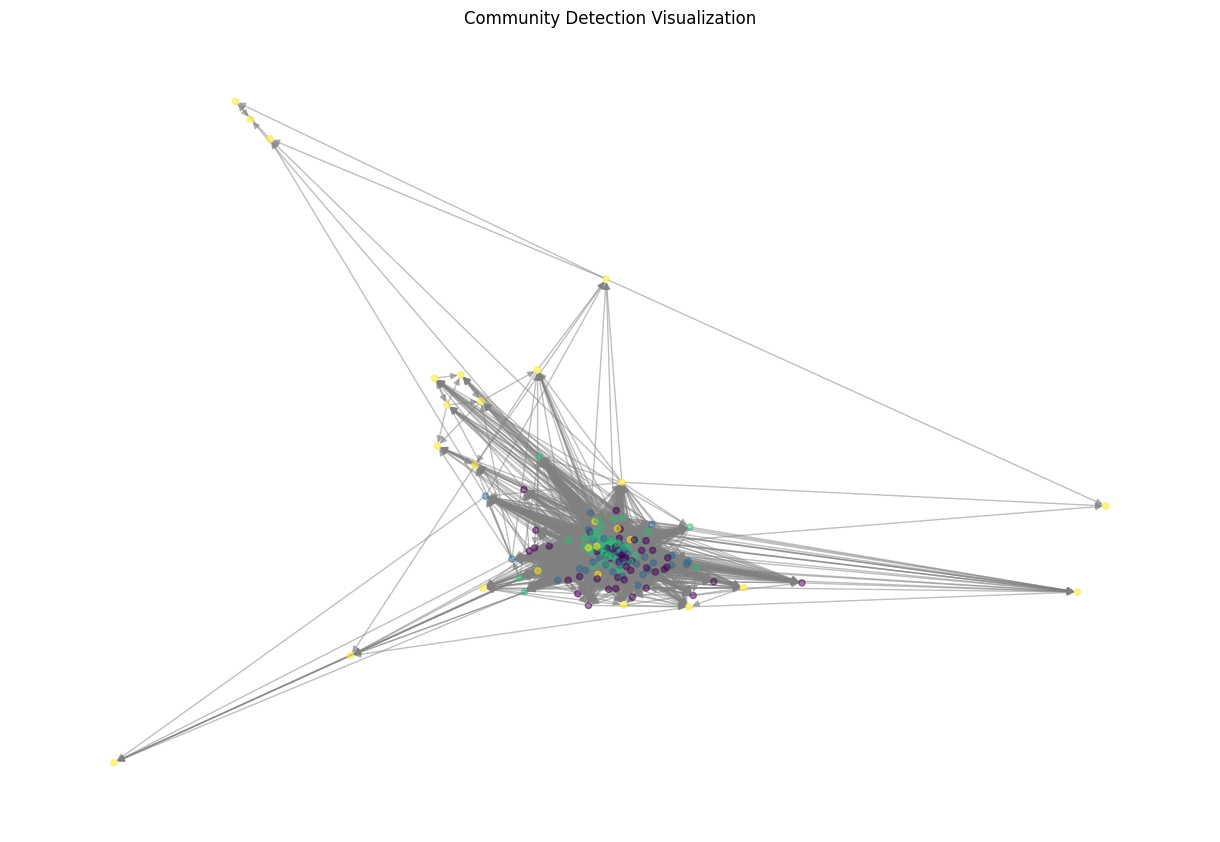

In [ ]:
import networkx as nx
import community  # python-louvain package
import matplotlib.pyplot as plt


# Number of communities
num_communities = len(set(partition.values()))
print(f"Number of detected communities: {num_communities}")

# Assign colors based on community
colors = [partition[node] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
nx.draw(G, pos, node_color=colors, node_size=20, edge_color="gray", alpha=0.5, with_labels=False, cmap=plt.cm.viridis)
plt.title("Community Detection Visualization")
plt.show()


In [ ]:
import networkx as nx
import community  # python-louvain package
import plotly.graph_objects as go

# Number of communities
num_communities = len(set(partition.values()))
print(f"Number of detected communities: {num_communities}")

# Generate layout positions for visualization
pos = nx.spring_layout(G, seed=42)

# Extract edges from the graph
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # None creates breaks in line segments
    edge_y.extend([y0, y1, None])

# Create an edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color="gray"),
    hoverinfo="none",
    mode="lines"
)

# Create node scatter plot with community colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(partition[node])  # Assign color based on community

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers",
    marker=dict(
        showscale=True,
        colorscale="Viridis",  # Color scheme for communities
        size=6,
        color=node_color,
        colorbar=dict(title="Community"),
    ),
    text=[f"Node {node}, Community {partition[node]}" for node in G.nodes()],
    hoverinfo="text"
)

# Create interactive plot
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title=f"Community Detection Visualization (Louvain) - {num_communities} Communities",
    title_x=0.5,
    showlegend=False,
    hovermode="closest",
    margin=dict(b=10, l=10, r=10, t=40),
    paper_bgcolor="white",
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


Number of detected communities: 4


In [ ]:
# Check if the graph is strongly or weakly connected
print(f"Is the graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Is the graph weakly connected? {nx.is_weakly_connected(G)}")

# Compute the average shortest path length (only for strongly connected graphs)
if nx.is_strongly_connected(G):
    print(f"Average Shortest Path Length: {nx.average_shortest_path_length(G):.2f}")


Is the graph strongly connected? False
Is the graph weakly connected? True


In [ ]:
largest_component = max(nx.weakly_connected_components(G), key=len)
G_sub = G.subgraph(largest_component)
print(f"Nodes in largest component: {len(G_sub.nodes())}")


Nodes in largest component: 198


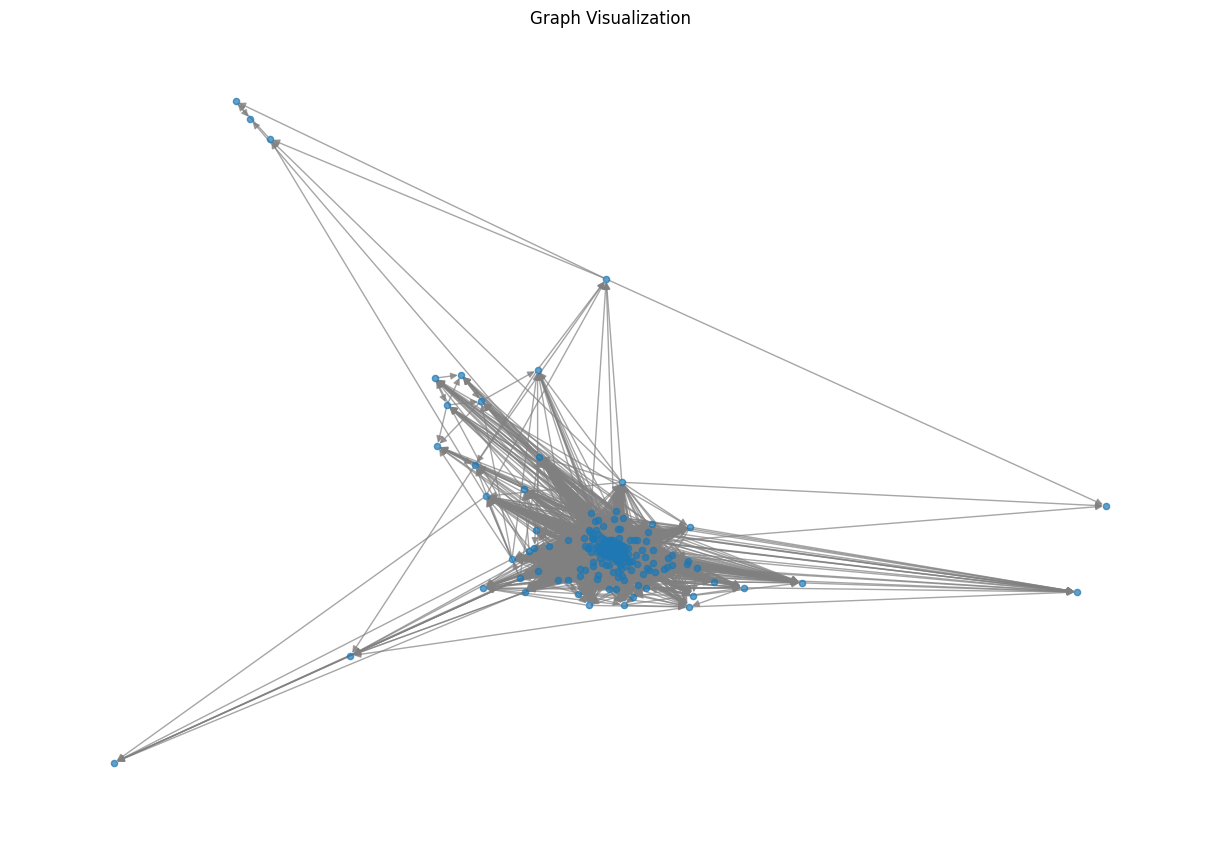

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
nx.draw(G, pos, node_size=20, edge_color="gray", alpha=0.7, with_labels=False)
plt.title("Graph Visualization")
plt.show()


In [ ]:
fake_news_spreaders = [node for node, label in node_labels.items() if label == 1]
print(f"Total Fake News Spreaders: {len(fake_news_spreaders)}")


Total Fake News Spreaders: 3


In [ ]:
G_fake = G.subgraph(fake_news_spreaders)
print(f"Fake News Subgraph - Nodes: {len(G_fake.nodes())}, Edges: {len(G_fake.edges())}")


Fake News Subgraph - Nodes: 3, Edges: 1


#OLD MODEL

In [ ]:
!pip install -q torch_geometric

In [ ]:

# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.6.0+cu124
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

In [ ]:
train_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
validate_data = UPFD(root=".", name="gossipcop", feature="content", split="val")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))
print("Validate Samples: ", len(validate_data))

Train Samples:  3826
Test Samples:  1092
Validate Samples:  546


In [ ]:
# for i in range(len(train_data)):
#   print(train_data[i])

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(validate_data, batch_size=128, shuffle=False)


In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# train_data.num_features

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds)).cpu().numpy()  # Move preds to CPU before converting to NumPy
    gts = torch.cat(gts).cpu().numpy()  # Move gts to CPU before converting to NumPy
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

def evaluate():
    model.eval()
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        all_preds.append(torch.round(torch.reshape(out, (-1,))).detach())  # Detach before appending
        all_labels.append(data.y.float().detach())

    preds = torch.cat(all_preds).cpu().numpy()
    gts = torch.cat(all_labels).cpu().numpy()

    cm = confusion_matrix(gts, preds)
    report = classification_report(gts, preds)

    # print("Confusion Matrix:")
    # print(cm)
    # print("Classification Report:")
    # print(report)

    return cm, report

In [ ]:
# Initialize CSV logging
csv_file = 'training_metrics.csv'
with open(csv_file, mode='w') as file:
    file.write('Epoch,TrainLoss,TestLoss,TestAcc,TestF1\n')

# Training loop with logging
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} | TrainLoss: {train_loss:.4f} | TestLoss: {test_loss:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')
    with open(csv_file, mode='a') as file:
        file.write(f'{epoch},{train_loss:.4f},{test_loss:.4f},{test_acc:.4f},{test_f1:.4f}\n')

Epoch: 00 | TrainLoss: 0.7092 | TestLoss: 0.6843 | TestAcc: 0.8370 | TestF1: 0.8053
Epoch: 01 | TrainLoss: 0.6907 | TestLoss: 0.6830 | TestAcc: 0.5101 | TestF1: 0.0000
Epoch: 02 | TrainLoss: 0.6831 | TestLoss: 0.7081 | TestAcc: 0.4899 | TestF1: 0.6577
Epoch: 03 | TrainLoss: 0.6560 | TestLoss: 0.6375 | TestAcc: 0.5302 | TestF1: 0.0790
Epoch: 04 | TrainLoss: 0.6046 | TestLoss: 0.7953 | TestAcc: 0.4899 | TestF1: 0.6577
Epoch: 05 | TrainLoss: 0.6216 | TestLoss: 0.5515 | TestAcc: 0.7894 | TestF1: 0.7288
Epoch: 06 | TrainLoss: 0.5398 | TestLoss: 0.4994 | TestAcc: 0.8910 | TestF1: 0.8968
Epoch: 07 | TrainLoss: 0.5187 | TestLoss: 0.4691 | TestAcc: 0.8379 | TestF1: 0.8053
Epoch: 08 | TrainLoss: 0.4626 | TestLoss: 0.4302 | TestAcc: 0.8984 | TestF1: 0.9041
Epoch: 09 | TrainLoss: 0.4262 | TestLoss: 0.4300 | TestAcc: 0.7839 | TestF1: 0.7197
Epoch: 10 | TrainLoss: 0.4102 | TestLoss: 0.4255 | TestAcc: 0.7720 | TestF1: 0.6982
Epoch: 11 | TrainLoss: 0.3920 | TestLoss: 0.3785 | TestAcc: 0.8608 | TestF1:

In [ ]:
cm, report = evaluate()

In [ ]:
cm

array([[431, 126],
       [  6, 529]])

In [ ]:
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87       557
         1.0       0.81      0.99      0.89       535

    accuracy                           0.88      1092
   macro avg       0.90      0.88      0.88      1092
weighted avg       0.90      0.88      0.88      1092



In [ ]:
import pandas as pd
import torch

# List to store results
results = []

# Iterate through the validation data loader
for data in test_loader:
    data = data.to(device)

    # Get model predictions
    gcn_out = model(data.x, data.edge_index, data.batch)

    # Average both predictions
    pred = gcn_out  # Shape: (batch_size, 1)

    # Store results
    for i in range(len(data.y)):
        results.append({
            "gcn_pred_logit": gcn_out[i].detach().cpu().numpy()[0],  # GCN output (raw score)
            "final_pred_logit": pred[i].detach().cpu().numpy()[0],  # Average prediction logit
            "final_pred": round(pred[i].detach().cpu().numpy()[0]),  # Rounded prediction (0 or 1)
            "true_label": data.y[i].cpu().numpy()  # Actual label
        })

In [ ]:
# Convert to DataFrame
df_test = pd.DataFrame(results)

# Display first few rows
print(df_test.head())

# Save to CSV if needed
df_test.to_csv("test_results_old.csv", index=False)

   gcn_pred_logit  final_pred_logit  final_pred true_label
0        0.256471          0.256471           0          0
1        0.910920          0.910920           1          1
2        0.996610          0.996610           1          1
3        0.141664          0.141664           0          0
4        0.214743          0.214743           0          0


In [ ]:
import pandas as pd
import torch

# List to store results
results = []

# Iterate through the validation data loader
for data in val_loader:
    data = data.to(device)

    # Get model predictions
    gcn_out = model(data.x, data.edge_index, data.batch)

    # Average both predictions
    pred = gcn_out # Shape: (batch_size, 1)

    # Store results
    for i in range(len(data.y)):
        results.append({
            "gcn_pred_logit": gcn_out[i].detach().cpu().numpy()[0],  # GCN output (raw score)
            "final_pred_logit": pred[i].detach().cpu().numpy()[0],  # Average prediction logit
            "final_pred": round(pred[i].detach().cpu().numpy()[0]),  # Rounded prediction (0 or 1)
            "true_label": data.y[i].cpu().numpy()  # Actual label
        })

# Convert to DataFrame
df_val = pd.DataFrame(results)

# Display first few rows
print(df_val.head())

# Save to CSV if needed
df_val.to_csv("validation_results.csv", index=False)

df_val

df_val.info()

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Extract true labels and final predictions

# Ensure labels are integers
df_val["true_label"] = df_val["true_label"].astype(int)
df_val["final_pred"] = df_val["final_pred"].astype(int)

y_true = df_val["true_label"]
y_pred = df_val["final_pred"]

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Generate classification report
report = classification_report(y_true, y_pred)

# Display results
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

   gcn_pred_logit  final_pred_logit  final_pred true_label
0        0.944808          0.944808           1          1
1        0.931327          0.931327           1          1
2        0.219582          0.219582           0          0
3        0.914865          0.914865           1          1
4        0.383747          0.383747           0          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gcn_pred_logit    546 non-null    float32
 1   final_pred_logit  546 non-null    float32
 2   final_pred        546 non-null    int64  
 3   true_label        546 non-null    object 
dtypes: float32(2), int64(1), object(1)
memory usage: 12.9+ KB
Validation Accuracy: 0.8718
Validation F1-Score: 0.8878
Validation Precision: 0.8076
Validation Recall: 0.9858

Confusion Matrix:
[[199  66]
 [  4 277]]

Classification Report:
              precis

# Our New Approach (Transformer + GCN + Reg Model)

In [ ]:
!pip install -q torch_geometric

In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear, TransformerEncoderLayer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

In [ ]:
# Custom Loss Function
class CombinedBCELoss(torch.nn.Module):
    def __init__(self, lambda_reg=0.01):
        super().__init__()
        self.lambda_reg = lambda_reg

    def forward(self, transformer_out, gcn_out, target, transformer_params, gcn_params):
        target = target.float()

        # BCE loss for transformer predictions
        L_T = torch.nn.functional.binary_cross_entropy(
            transformer_out.view(-1), target, reduction='mean'
        )

        # BCE loss for GCN predictions
        L_GCN = torch.nn.functional.binary_cross_entropy(
            gcn_out.view(-1), target, reduction='mean'
        )

        # Parameter regularization
        reg_term = sum(torch.norm(p, p=2) for p in transformer_params)
        reg_term += sum(torch.norm(p, p=2) for p in gcn_params)
        print("L_T",L_T ,"L_GCN",L_GCN,"reg_term",reg_term)
        # Total loss
        return L_T + L_GCN + self.lambda_reg * reg_term

In [ ]:

# Updated GNN Model
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super().__init__()

        # Transformer Component
        self.transformer = TransformerEncoderLayer(
            d_model=hidden_channels,
            nhead=num_heads,
            dim_feedforward=hidden_channels*2,
            batch_first=True
        )
        self.transformer_proj = Linear(in_channels, hidden_channels)

        # GCN Component
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout layers
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2 * hidden_channels, out_channels)

    def get_transformer_params(self):
        return [p for name, p in self.named_parameters() if 'transformer' in name]

    def get_gcn_params(self):
        return [p for name, p in self.named_parameters() if 'conv' in name]

    def forward(self, x, edge_index, batch):
        # GCN path
        h_gcn = self.conv1(x, edge_index).relu()
        h_gcn = self.conv2(h_gcn, edge_index).relu()
        h_gcn = self.conv3(h_gcn, edge_index).relu()
        h_gcn = gmp(h_gcn, batch)
        h_gcn = self.lin0(h_gcn).relu()

        # Transformer path
        h_trans = self.transformer_proj(x)
        h_trans = self.transformer(h_trans.unsqueeze(0)).squeeze(0)
        h_trans = gmp(h_trans, batch)

        # Include raw word2vec embeddings
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = x[root]
        news = self.lin_news(news).relu()

        # Final predictions for both paths
        gcn_out = torch.sigmoid(self.lin1(torch.cat([h_gcn, news], dim=-1)))
        trans_out = torch.sigmoid(self.lin1(torch.cat([h_trans, news], dim=-1)))

        return trans_out, gcn_out

In [ ]:
# Updated Training Function
def train(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        trans_out, gcn_out = model(data.x, data.edge_index, data.batch)
        loss = criterion(
            trans_out,
            gcn_out,
            data.y,
            model.get_transformer_params(),
            model.get_gcn_params()
        )
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

In [ ]:
# Metrics Function
def compute_metrics(preds, gts):
    preds = np.round(preds)
    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)
    return acc, f1

In [ ]:
# Updated Test Function
@torch.no_grad()
def test(epoch, model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        trans_out, gcn_out = model(data.x, data.edge_index, data.batch)
        # Use average of transformer and GCN predictions
        out = (trans_out + gcn_out) / 2
        loss = criterion(
            trans_out,
            gcn_out,
            data.y,
            model.get_transformer_params(),
            model.get_gcn_params()
        )
        total_loss += float(loss) * data.num_graphs
        all_preds.append(out.detach().cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy, f1 = compute_metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1


In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        trans_out, gcn_out = model(data.x, data.edge_index, data.batch)
        out = (trans_out + gcn_out) / 2
        all_preds.append(out.detach().cpu().numpy())
        all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    cm = confusion_matrix(all_labels, np.round(all_preds))
    report = classification_report(all_labels, np.round(all_preds))

    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

    return cm, report

In [ ]:
%pip install torchview visualtorch

In [ ]:
from torchview import draw_graph

# Create a sample data point with the required structure
sample_data = next(iter(train_loader))  # Get a batch from your train_loader
sample_data = sample_data.to(device)  # Move to the appropriate device

# Draw the graph using the sample data for input
model_graph = draw_graph(
    model,
    input_data=[sample_data.x, sample_data.edge_index, sample_data.batch],  # Provide all inputs
    expand_nested=True
)

# Save the graph as a PNG file
model_graph.visual_graph.render(filename='model_architecture', format='png')


'model_architecture.png'

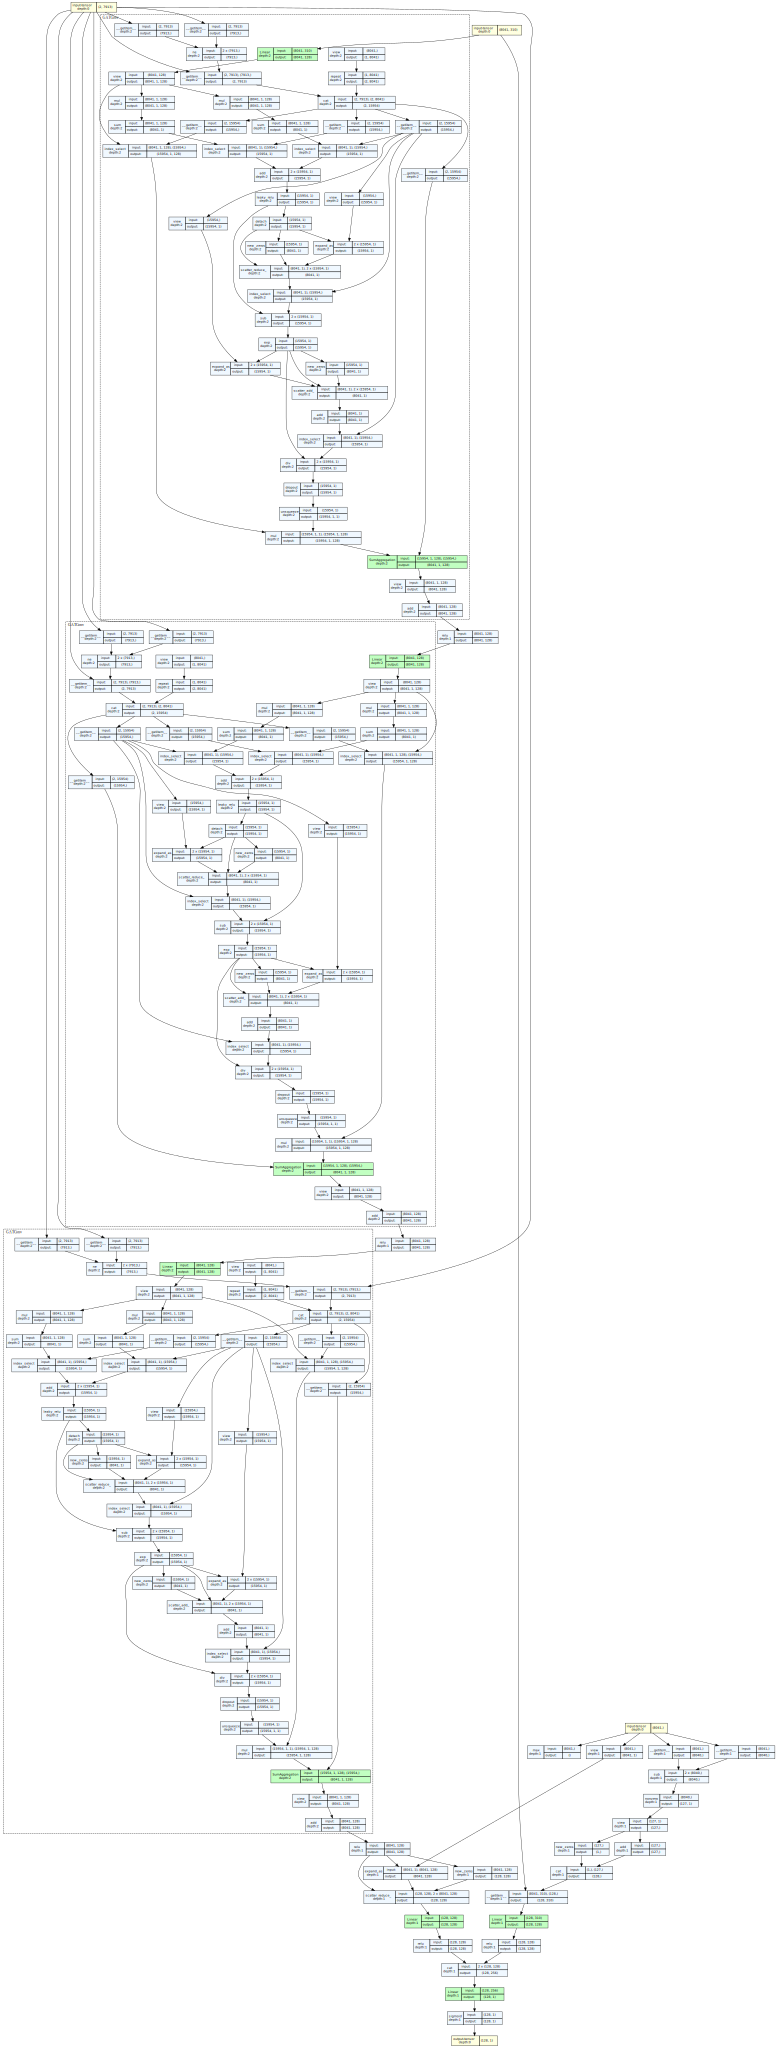

In [ ]:
from torchview import draw_graph

# Create a sample data point with the required structure
sample_data = next(iter(train_loader))  # Get a batch from your train_loader
sample_data = sample_data.to(device)  # Move to the appropriate device

# Draw the graph using the sample data for input
model_graph = draw_graph(
    model,
    input_data=[sample_data.x, sample_data.edge_index, sample_data.batch],  # Provide all inputs
    expand_nested=True
)

model_graph.visual_graph

In [ ]:
# for i in range(len(train_data)):
#   print(train_data[i])

In [ ]:
# for i in range(len(test_data)):
#   print(test_data[i])

In [ ]:
# Initialize model and components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = CombinedBCELoss(lambda_reg=0.01)

In [ ]:
# Data Loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(validate_data, batch_size=128, shuffle=False)

In [ ]:
import csv

csv_file = 'training_metrics_new.csv'
headers = ['Epoch', 'TrainLoss', 'TestLoss', 'TestAcc', 'TestF1']
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

best_test_acc = 0.0
target_accuracy = 1

for epoch in range(40):
    train_loss = train(epoch, model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1 = test(epoch, model, test_loader, criterion, device)
    print(f'Epoch: {epoch:02d} | TrainLoss: {train_loss:.4f} | TestLoss: {test_loss:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}')

    # Append metrics to the CSV file
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, train_loss, test_loss, test_acc, test_f1])

    # Check if the test accuracy has reached or exceeded the target
    if test_acc >= target_accuracy:
        print(f'Target test accuracy of {target_accuracy * 100}% reached at epoch {epoch:02d}. Stopping training.')
        break

    # Update the best test accuracy observed
    if test_acc > best_test_acc:
        best_test_acc = test_acc

L_T tensor(0.2825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) L_GCN tensor(0.2829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) reg_term tensor(3.9887, device='cuda:0', grad_fn=<AddBackward0>)
L_T tensor(0.1138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) L_GCN tensor(0.1241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) reg_term tensor(3.9078, device='cuda:0', grad_fn=<AddBackward0>)
L_T tensor(0.1757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) L_GCN tensor(0.1959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) reg_term tensor(3.8436, device='cuda:0', grad_fn=<AddBackward0>)
L_T tensor(0.2666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) L_GCN tensor(0.2817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) reg_term tensor(3.7893, device='cuda:0', grad_fn=<AddBackward0>)
L_T tensor(0.1974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) L_GCN tensor(0.2022, device='cuda:0', grad_fn=<BinaryCros

In [ ]:
cm, report = evaluate(model, test_loader, device)

In [ ]:
cm

In [ ]:
print(report)

In [ ]:
import pandas as pd
import torch

# List to store results
results = []

# Iterate through the validation data loader
for data in test_loader:
    data = data.to(device)

    # Get model predictions
    trans_out, gcn_out = model(data.x, data.edge_index, data.batch)

    # Average both predictions
    pred = (trans_out + gcn_out) / 2  # Shape: (batch_size, 1)

    # Store results
    for i in range(len(data.y)):
        results.append({
            "trans_pred_logit": trans_out[i].detach().cpu().numpy()[0],  # Transformer output (raw score)
            "gcn_pred_logit": gcn_out[i].detach().cpu().numpy()[0],  # GCN output (raw score)
            "final_pred_logit": pred[i].detach().cpu().numpy()[0],  # Average prediction logit
            "final_pred": round(pred[i].detach().cpu().numpy()[0]),  # Rounded prediction (0 or 1)
            "true_label": data.y[i].cpu().numpy()  # Actual label
        })

In [ ]:
# Convert to DataFrame
df_test = pd.DataFrame(results)

# Display first few rows
print(df_test.head())

# Save to CSV if needed
df_test.to_csv("test_results_new.csv", index=False)

In [ ]:
import pandas as pd
import torch

# List to store results
results = []

# Iterate through the validation data loader
for data in val_loader:
    data = data.to(device)

    # Get model predictions
    trans_out, gcn_out = model(data.x, data.edge_index, data.batch)

    # Average both predictions
    pred = (trans_out + gcn_out) / 2  # Shape: (batch_size, 1)

    # Store results
    for i in range(len(data.y)):
        results.append({
            "trans_pred_logit": trans_out[i].detach().cpu().numpy()[0],  # Transformer output (raw score)
            "gcn_pred_logit": gcn_out[i].detach().cpu().numpy()[0],  # GCN output (raw score)
            "final_pred_logit": pred[i].detach().cpu().numpy()[0],  # Average prediction logit
            "final_pred": round(pred[i].detach().cpu().numpy()[0]),  # Rounded prediction (0 or 1)
            "true_label": data.y[i].cpu().numpy()  # Actual label
        })

In [ ]:
# Convert to DataFrame
df_val = pd.DataFrame(results)

# Display first few rows
print(df_val.head())

# Save to CSV if needed
df_val.to_csv("validation_results_new.csv", index=False)

In [ ]:
df_val

In [ ]:
df_val.info()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
# Extract true labels and final predictions

# Ensure labels are integers
df_val["true_label"] = df_val["true_label"].astype(int)
df_val["final_pred"] = df_val["final_pred"].astype(int)

y_true = df_val["true_label"]
y_pred = df_val["final_pred"]

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Generate classification report
report = classification_report(y_true, y_pred)

In [ ]:
# Display results
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

#Hypothesis testing

In [ ]:
training_new = pd.read_csv("/content/training_metrics_new.csv")
training_new

,Epoch,TrainLoss,TestLoss,TestAcc,TestF1
0,0,2.335123,4.518931,0.489927,0.657652
1,1,1.880527,4.286295,0.489927,0.657652
2,2,1.591785,3.840805,0.489927,0.657652
3,3,1.295960,3.219381,0.489927,0.657652
4,4,1.052074,1.741927,0.577839,0.698101
5,5,0.854016,1.482833,0.704212,0.767123
6,6,0.742405,1.515380,0.754579,0.798496
7,7,0.796471,0.770071,0.925824,0.926297
8,8,0.633016,0.587987,0.930403,0.930018
9,9,0.560661,0.575193,0.925824,0.927743


In [ ]:
# prompt: training_metrics_old.csv
import pandas as pd
from scipy.stats import ttest_ind
# Load the CSV files into pandas DataFrames
training_old = pd.read_csv("training_metrics_old.csv")
training_new = pd.read_csv("training_metrics_new.csv")


In [ ]:
training_old

,Epoch,TrainLoss,TestLoss,TestAcc,TestF1
0,0,0.7219,0.7037,0.4899,0.6577
1,1,0.6930,0.6964,0.4899,0.6577
2,2,0.6778,0.6891,0.4899,0.6577
3,3,0.6836,0.6553,0.8654,0.8766
4,4,0.6591,0.6322,0.5971,0.7078
5,5,0.6212,0.6434,0.4899,0.6577
6,6,0.5615,0.5364,0.6740,0.5014
7,7,0.4915,0.4432,0.9084,0.9115
8,8,0.4447,0.3874,0.9212,0.9228
9,9,0.4545,0.4612,0.7647,0.8052


In [ ]:
training_new

,Epoch,TrainLoss,TestLoss,TestAcc,TestF1
0,0,2.335123,4.518931,0.489927,0.657652
1,1,1.880527,4.286295,0.489927,0.657652
2,2,1.591785,3.840805,0.489927,0.657652
3,3,1.295960,3.219381,0.489927,0.657652
4,4,1.052074,1.741927,0.577839,0.698101
5,5,0.854016,1.482833,0.704212,0.767123
6,6,0.742405,1.515380,0.754579,0.798496
7,7,0.796471,0.770071,0.925824,0.926297
8,8,0.633016,0.587987,0.930403,0.930018
9,9,0.560661,0.575193,0.925824,0.927743


In [ ]:
# Define the metrics to test
metrics = ['TrainLoss', 'TestLoss', 'TestAcc', 'TestF1']

# Initialize a dictionary to store t-test results
t_test_results = {}

# Perform t-tests for each metric
for metric in metrics:
    old_values = training_old[metric]
    new_values = training_new[metric]
    t_stat, p_value = ttest_ind(old_values, new_values, equal_var=True)
    t_test_results[metric] = {'t_statistic': t_stat, 'p_value': p_value}

# Display the results
for metric, results in t_test_results.items():
    print(f"Metric: {metric}")
    print(f"  t-statistic: {results['t_statistic']:.4f}")
    print(f"  p-value: {results['p_value']:.4f}")
    print()


Metric: TrainLoss
  t-statistic: -5.5008
  p-value: 0.0000

Metric: TestLoss
  t-statistic: -5.0738
  p-value: 0.0000

Metric: TestAcc
  t-statistic: 1.3957
  p-value: 0.1685

Metric: TestF1
  t-statistic: 0.5822
  p-value: 0.5628



In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp


In [ ]:
# Load the CSV files into pandas DataFrames
import pandas as pd
training_old_model = pd.read_csv("/content/training_metrics_old.csv")
training_new_model = pd.read_csv("/content/training_metrics_new.csv")


In [ ]:
# Define the metrics to plot
metrics = ['TrainLoss', 'TestLoss', 'TestAcc', 'TestF1']

# Create a subplot figure with 2 rows and 2 colu

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the CSV files into pandas DataFrames
training_old_model = pd.read_csv("training_metrics_old.csv")
training_new_model = pd.read_csv("training_metrics_new.csv")

# Define the metrics to plot
metrics = ['TrainLoss', 'TestLoss', 'TestAcc', 'TestF1']

# Create a subplot figure with 2 rows and 2 columns
fig = make_subplots(rows=2, cols=2, subplot_titles=metrics)

# Map each metric to a subplot
metric_positions = {
    'TrainLoss': (1, 1),
    'TestLoss': (1, 2),
    'TestAcc': (2, 1),
    'TestF1': (2, 2)
}

# Define colors for the old and new models
colors = {
    'old_model': 'blue',
    'new_model': 'red'
}

# Add traces for each metric
for i, metric in enumerate(metrics):
    row, col = metric_positions[metric]
    show_legend = i == 0  # Show legend only for the first subplot
    fig.add_trace(
        go.Scatter(
            x=training_old_model.index,
            y=training_old_model[metric],
            mode='lines',
            name='Old Model',
            line=dict(color=colors['old_model']),
            legendgroup='Old Model',
            showlegend=show_legend
        ),
        row=row, col=col
    )
    fig.add_trace(
        go.Scatter(
            x=training_new_model.index,
            y=training_new_model[metric],
            mode='lines',
            name='New Model',
            line=dict(color=colors['new_model']),
            legendgroup='New Model',
            showlegend=show_legend
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title='Training Metrics Comparison',
    height=800,
    width=1200
)

# Show plot
fig.show()


In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

# Load the CSV files into pandas DataFrames
training_old_model = pd.read_csv("training_metrics_old.csv")
training_new_model = pd.read_csv("training_metrics_new.csv")

# Define the metrics to test
metrics = ['TrainLoss', 'TestLoss', 'TestAcc', 'TestF1']

# Initialize a dictionary to store test results
test_results = {}

# Perform paired t-tests for each metric
for metric in metrics:
    old_values = training_old_model[metric]
    new_values = training_new_model[metric]
    t_stat, p_value = ttest_rel(old_values, new_values)
    test_results[metric] = {
        't_statistic': t_stat,
        'p_value': p_value,
        'old_mean': old_values.mean(),
        'new_mean': new_values.mean()
    }

# Display the test results with hypotheses and interpretations
for metric, results in test_results.items():
    print(f"Metric: {metric}")
    print(f"  Null Hypothesis (H₀): There is no significant difference in {metric} between the old and new models over the epochs.")
    print(f"  Alternative Hypothesis (H₁): There is a significant difference in {metric} between the old and new models over the epochs.")
    print(f"  Old Model Mean {metric}: {results['old_mean']:.4f}")
    print(f"  New Model Mean {metric}: {results['new_mean']:.4f}")
    print(f"  t-statistic: {results['t_statistic']:.4f}")
    print(f"  p-value: {results['p_value']:.4f}")
    if results['p_value'] < 0.05:
        print(f"  Result: Reject the null hypothesis (significant difference in {metric})")
        if metric in ['TrainLoss', 'TestLoss']:
            if results['new_mean'] < results['old_mean']:
                print(f"  Interpretation: The new model has a significantly lower {metric}, indicating better performance.")
            else:
                print(f"  Interpretation: The new model has a significantly higher {metric}, indicating worse performance.")
        else:  # For metrics like 'TestAcc' and 'TestF1'
            if results['new_mean'] > results['old_mean']:
                print(f"  Interpretation: The new model has a significantly higher {metric}, indicating better performance.")
            else:
                print(f"  Interpretation: The new model has a significantly lower {metric}, indicating worse performance.")
    else:
        print(f"  Result: Fail to reject the null hypothesis (no significant difference in {metric})")
        print(f"  Interpretation: There is no statistically significant difference in {metric} between the new and old models over the epochs.")
    print()


Metric: TrainLoss
  Null Hypothesis (H₀): There is no significant difference in TrainLoss between the old and new models over the epochs.
  Alternative Hypothesis (H₁): There is a significant difference in TrainLoss between the old and new models over the epochs.
  Old Model Mean TrainLoss: 0.3670
  New Model Mean TrainLoss: 0.5894
  t-statistic: -4.1059
  p-value: 0.0002
  Result: Reject the null hypothesis (significant difference in TrainLoss)
  Interpretation: The new model has a significantly higher TrainLoss, indicating worse performance.

Metric: TestLoss
  Null Hypothesis (H₀): There is no significant difference in TestLoss between the old and new models over the epochs.
  Alternative Hypothesis (H₁): There is a significant difference in TestLoss between the old and new models over the epochs.
  Old Model Mean TestLoss: 0.3727
  New Model Mean TestLoss: 0.8430
  t-statistic: -2.9870
  p-value: 0.0049
  Result: Reject the null hypothesis (significant difference in TestLoss)
  Int

In [ ]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# Load the CSV files into pandas DataFrames
old_model_df = pd.read_csv("/content/validation_results_old.csv")
new_model_df = pd.read_csv("/content/validation_results_new.csv")

In [ ]:
old_model_df

In [ ]:
new_model_df

In [ ]:
import pandas as pd

# Load the CSV files
df2 = pd.read_csv('/content/test_results_new.csv')
df1 = pd.read_csv('/content/test_results_old.csv')

# Check if 'true_label' columns are identical
labels_match = df1['true_label'].equals(df2['true_label'])
print(f"True labels match: {labels_match}")

True labels match: True


In [ ]:
!pip install statsmodels
from statsmodels.stats.contingency_tables import mcnemar

# ... (rest of the code remains the same) ...

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from tabulate import tabulate  # Importing the tabulate module

def perform_mcnemars_test(df1, df2, model1_name, model2_name):
    """
    Perform McNemar's test to compare two classification models.

    Parameters:
    - df1: DataFrame containing predictions and true labels for the first model.
    - df2: DataFrame containing predictions and true labels for the second model.
    - model1_name: Name of the first model (string).
    - model2_name: Name of the second model (string).
    """
    print(f"\n{'='*50}")
    print(f"McNemar's Test: {model1_name} vs {model2_name}")
    print(f"{'='*50}")

    # Extract predictions and true labels
    model1_preds = df1["final_pred"].values
    model2_preds = df2["final_pred"].values
    true_labels = df1["true_label"].values

    # Ensure that the true labels are identical in both dataframes
    if not np.array_equal(true_labels, df2["true_label"].values):
        raise ValueError("True labels do not match between the two datasets.")

    # Determine correctness of predictions
    correct_model1 = (model1_preds == true_labels)
    correct_model2 = (model2_preds == true_labels)

    # Calculate elements of the contingency table
    both_correct = np.sum(correct_model1 & correct_model2)
    both_incorrect = np.sum(~correct_model1 & ~correct_model2)
    model1_correct_only = np.sum(correct_model1 & ~correct_model2)
    model2_correct_only = np.sum(~correct_model1 & correct_model2)

    # Construct the contingency table
    contingency_table = np.array([[both_incorrect, model2_correct_only],
                                  [model1_correct_only, both_correct]])

    # Display the contingency table using tabulate
    table_headers = [f"{model2_name} Incorrect", f"{model2_name} Correct"]
    table_data = [
        [f"{model1_name} Incorrect", both_incorrect, model2_correct_only],
        [f"{model1_name} Correct", model1_correct_only, both_correct]
    ]
    print("\nContingency Table:")
    print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

    # Calculate accuracies
    model1_accuracy = (both_correct + model1_correct_only) / len(true_labels)
    model2_accuracy = (both_correct + model2_correct_only) / len(true_labels)

    # Display accuracy comparison
    print(f"\nAccuracy Comparison:")
    print(f"{model1_name} Accuracy: {model1_accuracy:.4f} ({both_correct + model1_correct_only}/{len(true_labels)})")
    print(f"{model2_name} Accuracy: {model2_accuracy:.4f} ({both_correct + model2_correct_only}/{len(true_labels)})")
    print(f"Accuracy Difference: {(model2_accuracy - model1_accuracy):.4f}")

    # Perform McNemar's test
    try:
        result = mcnemar(contingency_table, exact=False, correction=True)
        print(f"\nMcNemar's Test Results:")
        print(f"Chi-squared statistic: {result.statistic:.4f}")
        print(f"p-value: {result.pvalue:.6f}")

        # Interpretation
        alpha = 0.05
        if result.pvalue < alpha:
            print(f"\nResult: Significant difference (p < {alpha})")
            if model2_accuracy > model1_accuracy:
                print(f"The {model2_name} performs significantly better than the {model1_name}.")
            else:
                print(f"The {model1_name} performs significantly better than the {model2_name}.")
        else:
            print(f"\nResult: No significant difference (p >= {alpha})")
            print(f"There is no statistically significant difference between the models.")

    except Exception as e:
        print(f"Error performing McNemar's test: {e}")
        print("This can occur if one of the cells in the contingency table is zero.")

    # Additional error analysis
    model1_errors = np.sum(~correct_model1)
    model2_errors = np.sum(~correct_model2)
    print("\nError Analysis:")
    print(f"{model1_name} Total Errors: {model1_errors} ({model1_errors/len(true_labels):.4f})")
    print(f"{model2_name} Total Errors: {model2_errors} ({model2_errors/len(true_labels):.4f})")

    # Cases where models disagree
    disagree_count = model1_correct_only + model2_correct_only
    print(f"\nCases where models disagree: {disagree_count} ({disagree_count/len(true_labels):.4f})")

    # Confusion matrices for both models
    print(f"\nConfusion Matrix for {model1_name}:")
    cm1 = confusion_matrix(true_labels, model1_preds)
    print(cm1)

    print(f"\nConfusion Matrix for {model2_name}:")
    cm2 = confusion_matrix(true_labels, model2_preds)
    print(cm2)

# Example usage with your dataframes:
perform_mcnemars_test(df1, df2, "Old Model", "New Model")



McNemar's Test: Old Model vs New Model

Contingency Table:
+---------------------+-----------------------+---------------------+
|                     |   New Model Incorrect |   New Model Correct |
+=====================+=======================+=====================+
| Old Model Incorrect |                    28 |                  40 |
+---------------------+-----------------------+---------------------+
| Old Model Correct   |                     7 |                1017 |
+---------------------+-----------------------+---------------------+

Accuracy Comparison:
Old Model Accuracy: 0.9377 (1024/1092)
New Model Accuracy: 0.9679 (1057/1092)
Accuracy Difference: 0.0302

McNemar's Test Results:
Chi-squared statistic: 21.7872
p-value: 0.000003

Result: Significant difference (p < 0.05)
The New Model performs significantly better than the Old Model.

Error Analysis:
Old Model Total Errors: 68 (0.0623)
New Model Total Errors: 35 (0.0321)

Cases where models disagree: 47 (0.0430)

Confusion

In [ ]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# Define the contingency table
contingency_table = np.array([[28, 40],
                               [7, 1017]])

# Perform McNemar's test with continuity correction
result = mcnemar(contingency_table, exact=False, correction=True)

# Display the result
print(f'Statistic: {result.statistic}')
print(f'P-value: {result.pvalue}')


Statistic: 21.78723404255319
P-value: 3.046202480042495e-06


#make logging of loss


In [ ]:
import torch
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_max_pool as gmp
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Load datasets
train_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
validate_data = UPFD(root=".", name="gossipcop", feature="content", split="val")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))
print("Validate Samples: ", len(validate_data))

# Dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(validate_data, batch_size=128, shuffle=False)

# GNN model
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2 * hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()
        h = gmp(h, batch)
        h = self.lin0(h).relu()
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = x[root]
        news = self.lin_news(news).relu()
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def metrics(preds, gts):
    preds = torch.round(torch.cat(preds)).cpu().numpy()
    gts = torch.cat(gts).cpu().numpy()
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

@torch.no_grad()
def evaluate():
    model.eval()
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        all_preds.append(torch.round(torch.reshape(out, (-1,))).detach())
        all_labels.append(data.y.float().detach())
    preds = torch.cat(all_preds).cpu().numpy()
    gts = torch.cat(all_labels).cpu().numpy()
    cm = confusion_matrix(gts, preds)
    report = classification_report(gts, preds)
    return cm, report

# Logging
csv_file = 'training_metrics.csv'
with open(csv_file, 'w') as f:
    f.write('Epoch,TrainLoss,TestLoss,TestAcc,TestF1\n')
4
# Training loop
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f"Epoch: {epoch:02d} | TrainLoss: {train_loss:.4f} | TestLoss: {test_loss:.4f} | TestAcc: {test_acc:.4f} | TestF1: {test_f1:.4f}")
    with open(csv_file, 'a') as f:
        f.write(f'{epoch},{train_loss:.4f},{test_loss:.4f},{test_acc:.4f},{test_f1:.4f}\n')

# Evaluate after training
cm, report = evaluate()
print("\nFinal Confusion Matrix:\n", cm)
print("\nFinal Classification Report:\n", report)


Train Samples:  3826
Test Samples:  1092
Validate Samples:  546
Epoch: 00 | TrainLoss: 0.6981 | TestLoss: 0.6840 | TestAcc: 0.5110 | TestF1: 0.0037
Epoch: 01 | TrainLoss: 0.6893 | TestLoss: 0.6877 | TestAcc: 0.4899 | TestF1: 0.6577
Epoch: 02 | TrainLoss: 0.6823 | TestLoss: 0.6721 | TestAcc: 0.4899 | TestF1: 0.6577
Epoch: 03 | TrainLoss: 0.6705 | TestLoss: 0.6548 | TestAcc: 0.4899 | TestF1: 0.6577
Epoch: 04 | TrainLoss: 0.6379 | TestLoss: 0.5984 | TestAcc: 0.7839 | TestF1: 0.7197
Epoch: 05 | TrainLoss: 0.5801 | TestLoss: 0.5382 | TestAcc: 0.8581 | TestF1: 0.8356
Epoch: 06 | TrainLoss: 0.5434 | TestLoss: 0.5544 | TestAcc: 0.6154 | TestF1: 0.7174
Epoch: 07 | TrainLoss: 0.5097 | TestLoss: 0.4513 | TestAcc: 0.9167 | TestF1: 0.9141
Epoch: 08 | TrainLoss: 0.4494 | TestLoss: 0.4187 | TestAcc: 0.8919 | TestF1: 0.8798
Epoch: 09 | TrainLoss: 0.4144 | TestLoss: 0.3927 | TestAcc: 0.8782 | TestF1: 0.8619
Epoch: 10 | TrainLoss: 0.3863 | TestLoss: 0.4056 | TestAcc: 0.7995 | TestF1: 0.7451
Epoch: 11 | 

In [ ]:
old_loss = pd.read_csv("/content/training_metrics.csv")
old_loss['TrainLoss'].iloc[-1]


np.float64(0.2559)

In [ ]:
new_loss = pd.read_csv("/content/detailed_loss_log.csv")
new_loss.iloc[-1]

,1199
Epoch,39.000000
Batch,29.000000
TotalLoss,0.309964
L_T,0.115354
L_GCN,0.158965
RegTerm,3.564600


In [ ]:
import pandas as pd

# Load data
old_loss = pd.read_csv("/content/training_metrics.csv")
new_loss = pd.read_csv("/content/detailed_loss_log.csv")

# Aggregate new_loss by epoch — using last batch of each epoch
new_loss_by_epoch = new_loss.groupby('Epoch').tail(1).reset_index(drop=True)

# Merge the DataFrames on 'Epoch'
merged_df = pd.merge(old_loss, new_loss_by_epoch, on='Epoch', how='inner')

# Keep every 5th epoch for comparison
comparison_df = merged_df.iloc[::5]

# Show the result
comparison_df


,Epoch,TrainLoss,TestLoss,TestAcc,TestF1,Batch,TotalLoss,L_T,L_GCN,RegTerm
0,0,0.6981,0.6840,0.5110,0.0037,29,2.045706,0.571370,0.691530,78.280548
5,5,0.5801,0.5382,0.8581,0.8356,29,1.005909,0.395299,0.461002,14.960824
10,10,0.3863,0.4056,0.7995,0.7451,29,0.600899,0.233801,0.263470,10.362690
15,15,0.3158,0.3909,0.7866,0.7223,29,0.343475,0.108217,0.167448,6.781060
20,20,0.2754,0.3077,0.8764,0.8577,29,0.408805,0.163884,0.181559,6.336218
25,25,0.2686,0.2332,0.9460,0.9458,29,0.286605,0.069759,0.158937,5.790870
30,30,0.2377,0.2318,0.9405,0.9378,29,0.351044,0.126011,0.183000,4.203332
35,35,0.2393,0.2144,0.9505,0.9502,29,0.469878,0.213079,0.216057,4.074241
